In [1]:
# -*- coding: utf-8 -*-
"""Full Scene Editing Pipeline with Depth Estimation"""

# Install required packages
#!pip install torch torchvision wget
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=5ae7791ecf967c601aec9bd1eab5e60c35f346106477a52563411b046c727bd7
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:

import os
import wget
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.model_zoo import model_zoo
import numpy as np
import cv2
import torchvision.transforms as T
import torchvision.models as models_tv


In [3]:
import os
import wget
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# --- Download Places365 model if not already present ---
os.makedirs("models", exist_ok=True)
places365_url = "http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar"
model_path = "models/resnet50_places365.pth.tar"
if not os.path.exists(model_path):
    print("📥 Downloading Places365 model...")
    wget.download(places365_url, model_path)

# --- Load Places365 ResNet50 Model ---
scene_model = models.resnet50(num_classes=365)
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
state_dict = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}
scene_model.load_state_dict(state_dict)
scene_model.eval()

# --- Load label list for Places365 ---
label_file = 'categories_places365.txt'
if not os.path.exists(label_file):
    print("\n📥 Downloading Places365 categories...")
    wget.download('https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt', label_file)
classes = [line.strip().split(' ')[0][3:] for line in open(label_file)]

# --- Umbrella Category Definitions ---
CATEGORY_GROUPS = {
    "living room": {
        "living_room", "family_room", "lounge", "den", "television_room", "playroom",
        "recreation_room", "home_theater", "artists_loft"
    },
    "kitchen": {
        "kitchen", "dining_room", "pantry", "restaurant_kitchen", "cafeteria", "food_court"
    },
    "bathroom": {
        "bathroom", "shower", "jacuzzi/indoor", "sauna"
    },
    "bedroom": {
        "bedroom", "childs_room", "bedchamber", "dorm_room","attic"
    },
    "open environment": {
        "mountain", "desert/sand", "desert/vegetation", "beach", "forest_path", "forest/broadleaf",
        "park", "field/cultivated", "field/wild", "field_road", "plaza", "highway", "viaduct",
        "mountain_path", "mountain_snowy", "rainforest", "lake/natural", "river", "valley",
        "vineyard", "wheat_field", "swamp", "glacier"
    }
}

def classify_scene(scene_label):
    """Classify fine-grained scene label into umbrella category."""
    for umbrella, group in CATEGORY_GROUPS.items():
        if scene_label in group:
            return umbrella
    return "other indoor"

# --- Load Image ---
img_path = '/kaggle/input/image1/bedroom1.jpg'  # <-- change to your actual image path
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found at: {img_path}")

img = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_img = transform(img).unsqueeze(0)

# --- Predict Scene ---
with torch.no_grad():
    logits = scene_model(input_img)
    probs = nn.functional.softmax(logits, dim=1)
    top_probs, top_idxs = probs.topk(5)
    predicted_scene = classes[top_idxs[0][0]]

# --- Show Top Predictions ---
print("\n🔍 Top Scene Predictions:")
for i in range(top_probs.size(1)):
    print(f"{classes[top_idxs[0][i]]}: {top_probs[0][i].item():.4f}")

# --- Determine Umbrella Category ---
scene_base = predicted_scene.split('/')[-1]  # e.g., 'dining_room'
scene_category = classify_scene(scene_base)

print(f"\n📌 Detected scene base: {scene_base}")
print(f"🏷️ Scene categorized under: {scene_category}")

# --- Chair Placement Safety Check ---
if scene_category == "open environment":
    user_input = input("⚠️ This is not an ideal place for chair placement. Do you want to continue? (yes/no): ").strip().lower()
    if user_input != "yes":
        print("🛑 Chair placement aborted.")
    else:
        print("✅ Proceeding with chair placement.")
else:
    print(f"✅ Proceeding with chair placement in a '{scene_category}' environment.")


📥 Downloading Places365 model...

📥 Downloading Places365 categories...

🔍 Top Scene Predictions:
attic: 0.5025
bedchamber: 0.1672
bedroom: 0.1150
alcove: 0.0663
bow_window/indoor: 0.0485

📌 Detected scene base: attic
🏷️ Scene categorized under: bedroom
✅ Proceeding with chair placement in a 'bedroom' environment.


model_final_cafdb1.pkl: 261MB [00:01, 208MB/s]                             
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



[INFO] Scene Category: bedroom
[INFO] Placeable Labels: ['floor', 'bed', 'rug']

[DEBUG] Detected Segment Labels:
[WARNING] Category ID 59 not found.
[WARNING] Category ID 56 not found.
[WARNING] Category ID 56 not found.
[WARNING] Category ID 74 not found.
  ID:  5 | Label: light
  ID:  6 | Label: mirror-stuff
  ID:  7 | Label: window
  ID:  8 | Label: ceiling
  ID:  9 | Label: cabinet
  ID: 10 | Label: floor
    --> ✅ Marked as placeable surface
  ID: 11 | Label: wall
  ID: 12 | Label: rug
    --> ✅ Marked as placeable surface


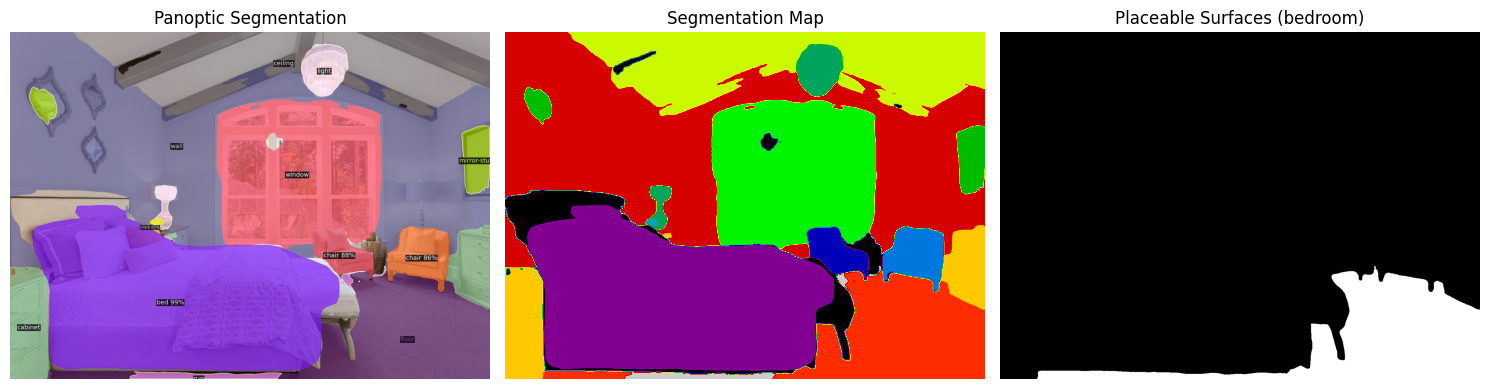

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer

# --- Setup Detectron2 ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

# --- Run segmentation ---
img_np = np.array(img)[:, :, ::-1]  # RGB to BGR
outputs = predictor(img_np)
panoptic_seg, segments_info = outputs["panoptic_seg"]

# --- Scene-specific placeable label map ---
scene_to_surfaces = {
    "living room": ["floor", "rug", "table","chair","couch"],
    "dining_room": ["floor", "rug", "table","dining table","chair"],
    "artists_loft": ["floor", "rug", "table","chair","couch"],
    "study": ["floor", "rug", "table","chair","couch"],
    "dining_hall": ["floor", "rug", "table"],
    "banquet_hall": ["floor", "rug", "table"],
    "bedroom": ["floor", "bed", "rug"],
    "kitchen": ["floor", "counter", "table"],
    "attic": ["floor", "rug"],
    "open environment": ["grass", "dirt", "ground", "soil", "sand", "path"]
}

# Get surface labels for predicted category
placeable_labels = scene_to_surfaces.get(scene_category, ["floor"])
print(f"\n[INFO] Scene Category: {scene_category}")
print(f"[INFO] Placeable Labels: {placeable_labels}")

metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0] if cfg.DATASETS.TEST else cfg.DATASETS.TRAIN[0])
placeable_ids = []

print("\n[DEBUG] Detected Segment Labels:")
for segment in segments_info:
    category_id = segment["category_id"]
    try:
        category_name = metadata.stuff_classes[category_id]
    except IndexError:
        print(f"[WARNING] Category ID {category_id} not found.")
        continue

    print(f"  ID: {segment['id']:2} | Label: {category_name}")
    if any(label in category_name.lower() for label in placeable_labels):
        print("    --> ✅ Marked as placeable surface")
        placeable_ids.append(segment["id"])

# --- Create binary mask
placeable_mask = np.isin(panoptic_seg.cpu().numpy(), placeable_ids)

# --- Plot Results ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
v = Visualizer(img_np[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.imshow(out.get_image())
plt.title("Panoptic Segmentation")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(panoptic_seg.cpu(), cmap="nipy_spectral")
plt.title("Segmentation Map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(placeable_mask, cmap="gray")
plt.title(f"Placeable Surfaces ({scene_category})")
plt.axis("off")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

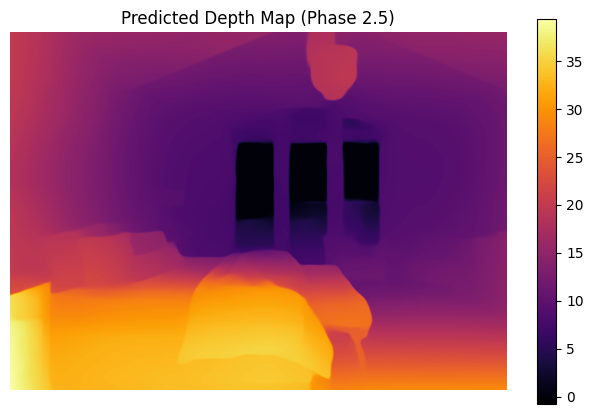

In [5]:

import urllib
import cv2
import torch.hub
import torchvision.transforms as T

# Load MiDaS model
# Load MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")  # or use "MiDaS_small" for speed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# Load transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform if "DPT" in str(midas) else midas_transforms.small_transform

# Convert PIL image to RGB numpy
img_rgb = np.array(img.convert("RGB"))

# Apply transform and predict
input_batch = transform(img_rgb).to(device)


with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Visualize depth map
plt.figure(figsize=(8, 5))
plt.imshow(depth_map, cmap='inferno')
plt.title("Predicted Depth Map (Phase 2.5)")
plt.axis("off")
plt.colorbar()
plt.savefig("/kaggle/working/depth_map.png", bbox_inches='tight', pad_inches=0)
plt.show()



model_final_f10217.pkl: 178MB [00:01, 176MB/s]                             


Detected 2 chair(s).


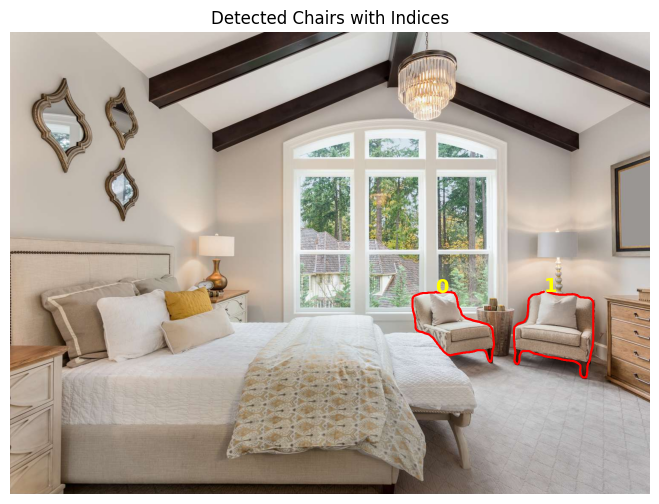

In [6]:
# --- Phase 3: Object Detection and Optional Replacement (Improved) on 16/06/25---
# What This Fixes:
# 1, Index visibility	- All detected tables now show up with numbers overlaid on the image.
# 2, User selection	- User sees image with indices → chooses from dropdown (via input()) with clear guidance.
# 3, Proper object removal	- The selected table is now masked (blacked out) in img_np_removed. You can pass this to inpainting later.
# 4, Overlapping tables are considered the same. If there is 80 percent overlap they are the same

import ipywidgets as widgets
from IPython.display import display

cfg_instance = get_cfg()
cfg_instance.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_instance.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg_instance.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg_instance.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor_instance = DefaultPredictor(cfg_instance)

outputs_instance = predictor_instance(img_np)
instances = outputs_instance["instances"]
coco_metadata = MetadataCatalog.get("coco_2017_val")
coco_classes = coco_metadata.thing_classes

target_class_name = "chair"
try:
    target_class_idx = coco_classes.index(target_class_name)
except ValueError:
    raise ValueError(f"'{target_class_name}' not found in COCO classes.")

target_instances = instances[instances.pred_classes == target_class_idx]
from detectron2.structures import pairwise_iou

masks = target_instances.pred_masks
keep = []
for i in range(len(masks)):
    overlap = False
    for j in keep:
        iou = (masks[i] & masks[j]).sum().float() / (masks[i] | masks[j]).sum().float()
        if iou > 0.8:  # 80% overlap = likely duplicate
            overlap = True
            break
    if not overlap:
        keep.append(i)
target_instances = target_instances[keep]

# Show all detected tables with index overlay
if len(target_instances) == 0:
    print(f"No {target_class_name}(s) detected in the scene.")
    replacement_mask = None
else:
    print(f"Detected {len(target_instances)} {target_class_name}(s).")

    # Visualize all tables with labels
    plt.figure(figsize=(10, 6))
    plt.imshow(img_np[:, :, ::-1])
    for i in range(len(target_instances)):
        mask = target_instances.pred_masks[i].cpu().numpy()
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='red')
        # Label with index
        y, x = np.where(mask)
        if len(x) > 0 and len(y) > 0:
            plt.text(x[0], y[0], str(i), color='yellow', fontsize=14, weight='bold')
    plt.title("Detected Chairs with Indices")
    plt.axis("off")
    plt.show()


🪑 Detected 2 chair(s) in the image.


Do you want to replace an existing chair (r) or place a new one (n)? [r/n]:  r


Multiple chairs detected:
  → Chair 0: area = 18568 pixels
  → Chair 1: area = 26011 pixels


Enter index (0 to 1) of the chair to replace:  0


⚠️ Warning: Far object (high depth).


Continue replacing? (y/n):  y


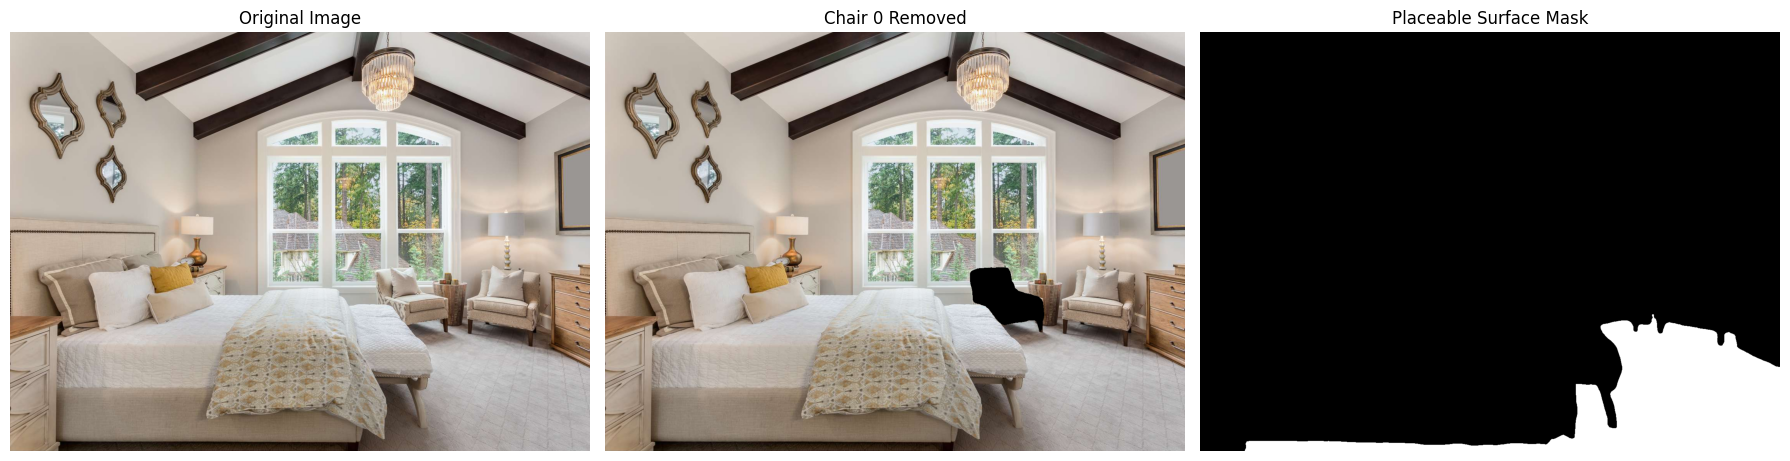

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

MIN_AREA_THRESHOLD = 1500
MAX_DEPTH_THRESHOLD = 0.6

replacement_mask = None
new_point = None

# --- Function to check if a click is valid ---
def is_click_valid(x, y, mask):
    return 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1] and mask[int(y), int(x)] == 1

# --- Function to prompt for a valid click ---
def prompt_click_on_placeable_region(img_display, placeable_mask):
    """Ask user to click a point using ginput (Colab/Jupyter compatible)."""
    while True:
        print("🔍 Please click on a valid placeable surface...")

        plt.figure(figsize=(8, 6))
        plt.imshow(img_display)
        plt.title("Click on a valid placeable region and then CLOSE the window")
        clicks = plt.ginput(1, timeout=0)  # Wait for one click
        plt.close()

        if clicks:
            x, y = int(clicks[0][0]), int(clicks[0][1])
            print(f"[DEBUG] Clicked at ({x}, {y})")
            if is_click_valid(x, y, placeable_mask):
                print(f"✅ Valid click at ({x}, {y}) inside placeable region.")
                return (x, y)
            else:
                print(f"❌ Click at ({x}, {y}) is outside placeable region.")
        else:
            print("⚠️ No click registered.")

        retry = input("⚠️ No valid point selected. Try again? (y/n): ").strip().lower()
        if retry != 'y':
            print("⛔ Placement cancelled by user.")
            return None


# --- Convert image for display ---
img_display = img_np[:, :, ::-1]  # Convert BGR to RGB for display

# --- Main logic starts here ---
if len(target_instances) != 0:
    print(f"🪑 Detected {len(target_instances)} chair(s) in the image.")
    action = input("Do you want to replace an existing chair (r) or place a new one (n)? [r/n]: ").strip().lower()

    if action == 'r':
        # --- Replace chair logic ---
        if len(target_instances) > 1:
            print("Multiple chairs detected:")
            for idx, mask in enumerate(target_instances.pred_masks):
                area = mask.sum().item()
                print(f"  → Chair {idx}: area = {area:.0f} pixels")

            while True:
                try:
                    selected_idx = int(input(f"Enter index (0 to {len(target_instances)-1}) of the chair to replace: "))
                    if 0 <= selected_idx < len(target_instances):
                        break
                    else:
                        print("Invalid index. Try again.")
                except ValueError:
                    print("Invalid input. Please enter a number.")
        else:
            selected_idx = 0

        replacement_mask = target_instances.pred_masks[selected_idx].cpu().numpy()
        area = replacement_mask.sum()
        masked_depth = depth_map[replacement_mask]
        avg_depth = masked_depth.mean()

        if area < MIN_AREA_THRESHOLD:
            print("⚠️ Warning: Small region — may be congested.")
            if input("Continue replacing? (y/n): ").strip().lower() != 'y':
                replacement_mask = None

        elif avg_depth > MAX_DEPTH_THRESHOLD:
            print("⚠️ Warning: Far object (high depth).")
            if input("Continue replacing? (y/n): ").strip().lower() != 'y':
                replacement_mask = None

        if replacement_mask is not None:
    # Mask and remove the chair
            img_np_removed = img_np.copy()
            img_np_removed[replacement_mask] = 0
            img_np_removed_display = img_np_removed[:, :, ::-1]  # BGR → RGB

    # Show original image, masked image, and placeable region
            plt.figure(figsize=(18, 5))

    # Original
            plt.subplot(1, 3, 1)
            plt.imshow(img_display)
            plt.title("Original Image")
            plt.axis("off")
            
    # Masked (chair removed)
            plt.subplot(1, 3, 2)
            plt.imshow(img_np_removed_display)
            plt.title(f"Chair {selected_idx} Removed")
            plt.axis("off")
            plt.savefig("/kaggle/working/removed.png", bbox_inches='tight', pad_inches=0)

    # Placeable Mask
            plt.subplot(1, 3, 3)
            plt.imshow(placeable_mask, cmap="gray")
            plt.title("Placeable Surface Mask")
            plt.axis("off")
            
            plt.tight_layout()
            plt.savefig("/kaggle/working/placable_surface.png", bbox_inches='tight', pad_inches=0)
            plt.show()

    elif action == 'n':
        print("🔍 Click on the placeable surface to choose a point for new chair placement.")
        new_point = prompt_click_on_placeable_region(img_display, placeable_mask)
        if new_point:
            print(f"📍 Final placement point selected: {new_point}")
    else:
        print("❌ Invalid input. Please enter 'r' or 'n'.")

else:
    print("✅ No chairs found. Proceeding with new placement.")
    new_point = prompt_click_on_placeable_region(img_display, placeable_mask)
    if new_point:
        print(f"📍 Final placement point selected: {new_point}")

# Final outputs:
# - `replacement_mask`: Mask of removed chair (if applicable)
# - `new_point`: (x, y) coordinate of new chair location


In [9]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python torch torchvision
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import ipywidgets as widgets
from IPython.display import display

# --- Load SAM Model ---
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

# --- Load Object Image (for reference, not used for placement) ---
object_img = cv2.imread("/kaggle/input/image1/chair.jpeg")
object_rgb = cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(object_rgb)

if not masks:
    raise RuntimeError("No objects found with SAM.")

largest = max(masks, key=lambda m: m["area"])
mask = largest["segmentation"].astype(np.uint8)

x, y, w, h = cv2.boundingRect(mask)
cropped_obj = object_img[y:y+h, x:x+w]
cropped_mask = (mask[y:y+h, x:x+w] * 255).astype(np.uint8)

# --- Helper: Estimate Rotation from Hough Lines ---
def estimate_floor_angle(img, mask):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 120)
    if lines is not None:
        angles = [(theta - np.pi/2) * 180 / np.pi for _, theta in lines[:, 0]]
        return np.median(angles)
    return 0

def rotate_image_and_mask(img, mask, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h)), cv2.warpAffine(mask, M, (w, h))

# --- Load Background Image and Depth Map ---
# img_np: BGR background image
# depth_map: 2D float32 array
# placeable_mask: binary mask of placeable surface
# new_point: (x, y) user selected

# These should be provided externally by your pipeline
assert "img_np" in globals() and "depth_map" in globals() and "placeable_mask" in globals()

if 'new_point' not in globals() or new_point is None:
    print("⚠️ new_point is not defined. Defaulting to center of image.")
    px, py = img_np.shape[1] // 2, img_np.shape[0] // 2
else:
    px, py = new_point

# --- Depth-Aware Scaling ---
depth_at = depth_map[py, px]
depth_near = np.percentile(depth_map[placeable_mask], 5)
depth_far = np.percentile(depth_map[placeable_mask], 95)
norm = np.clip((depth_at - depth_near) / (depth_far - depth_near + 1e-6), 0.0, 1.0)
initial_scale = 1.0 - norm**2 * 0.6
initial_scale = np.clip(initial_scale, 0.3, 1.0)

# --- Interactive Preview Function ---
def update_preview(x=px, y=py, scale_slider=initial_scale, angle_slider=0):
    try:
        # Inpainting the target region if replacement_mask is defined
        if 'replacement_mask' in globals() and replacement_mask is not None:
            inpainted = cv2.inpaint(img_np, (replacement_mask * 255).astype(np.uint8), 3, cv2.INPAINT_TELEA)
        else:
            inpainted = img_np.copy()

        # Draw bounding boxes on inpainted image
        temp_mask = placeable_mask.copy()
        if 'replacement_mask' in globals() and replacement_mask is not None:
            temp_mask = np.logical_or(temp_mask, replacement_mask).astype(np.uint8)

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(temp_mask, connectivity=8)
        output_image = inpainted.copy()

        print(f"🔲 Found {num_labels - 1} placeable regions (including replacement if any).")
        for i in range(1, num_labels):
            x_box, y_box, w, h, area = stats[i]
            cx, cy = centroids[i]
            if area < 500:
                continue
            cv2.rectangle(output_image, (x_box, y_box), (x_box + w, y_box + h), (0, 255, 0), 2)
            cv2.putText(output_image, f"{i}", (x_box, y_box - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            print(f"🟩 Region {i}: x={x_box}, y={y_box}, w={w}, h={h}, area={area}")

        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Position: ({x},{y}), Scale: {scale_slider:.2f}, Rotation: {angle_slider} deg")
        plt.axis("off")
        plt.savefig("/kaggle/working/phase6_input_image.png", bbox_inches='tight', pad_inches=0)  # Save the plot as an image
        plt.show()
    except Exception as e:
        print("❌ Failed to inpaint or draw boxes:", e)

# --- Show Sliders ---
widgets.interact(
    update_preview,
    x=widgets.IntSlider(value=px, min=0, max=img_np.shape[1]),
    y=widgets.IntSlider(value=py, min=0, max=img_np.shape[0]),
    scale_slider=widgets.FloatSlider(value=initial_scale, min=0.3, max=1.5, step=0.05),
    angle_slider=widgets.IntSlider(value=0, min=-45, max=45, step=5)
);

# --- Optionally show estimated rotation ---
angle = estimate_floor_angle(img_np, placeable_mask)
print(f"🧭 Estimated floor alignment angle: {angle:.2f} degrees")


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-rrq9ecu7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-rrq9ecu7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2025-06-23 08:32:59--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.244.202.73, 18.244.202.62, 18.244.202.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.244.202.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   315MB/s    in 7.9s    

2025-06-23 08:33:07 (309 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

⚠️ n

interactive(children=(IntSlider(value=750, description='x', max=1500), IntSlider(value=542, description='y', m…

🧭 Estimated floor alignment angle: -3.00 degrees


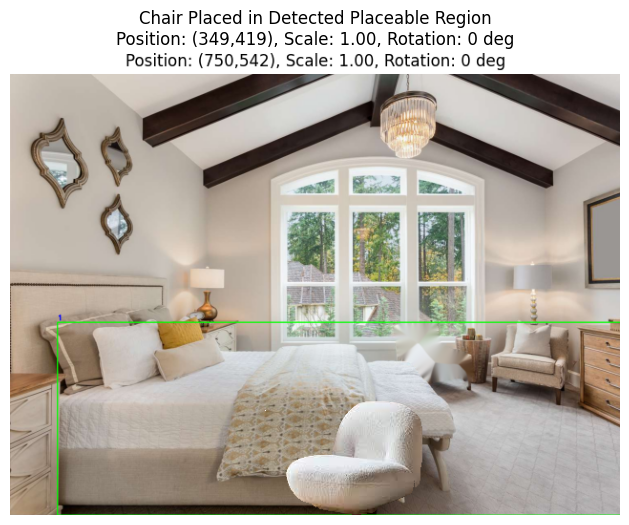

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load chair image and SAM
object_img = cv2.imread("/kaggle/input/image1/chair.jpeg")
object_rgb = cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB)

# Load SAM
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

# Generate mask
masks = mask_generator.generate(object_rgb)
best_mask = max(masks, key=lambda m: m["area"])
mask = best_mask["segmentation"].astype(np.uint8)

# === Expand mask bounding box more aggressively ===
x, y, w, h = cv2.boundingRect(mask)
expand_top = int(0.3 * h)  # Increase upper expansion to 30%
y_new = max(0, y - expand_top)
h_new = h + (y - y_new)

cropped_obj = object_img[y_new:y_new + h_new, x:x + w]
cropped_mask = (mask[y_new:y_new + h_new, x:x + w] * 255).astype(np.uint8)

# === Resize & Rotate Function ===
def rotate_image_and_mask(img, mask, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return (
        cv2.warpAffine(img, M, (w, h)),
        cv2.warpAffine(mask, M, (w, h))
    )

# === Placeholder scene inputs (replace with your own if needed) ===
img_np = cv2.imread("/kaggle/working/phase6_input_image.png")  # background
depth_map = np.ones((img_np.shape[0], img_np.shape[1]), dtype=np.float32) * 5  # dummy depth
placeable_mask = np.zeros((img_np.shape[0], img_np.shape[1]), dtype=np.uint8)
placeable_mask[360:480, 200:500] = 1  # fake flat region

# === Depth-aware scaling ===
px, py = 250, 180  # new_point
depth_at = depth_map[py, px]
depth_near = np.percentile(depth_map[placeable_mask > 0], 5)
depth_far = np.percentile(depth_map[placeable_mask > 0], 95)
norm = np.clip((depth_at - depth_near) / (depth_far - depth_near + 1e-6), 0.0, 1.0)
initial_scale = np.clip(1.0 - norm**2 * 0.6, 0.3, 1.0)
angle = 0  # you can use estimated floor angle

# === Resize and rotate chair ===
scaled_obj = cv2.resize(cropped_obj, (0, 0), fx=initial_scale, fy=initial_scale, interpolation=cv2.INTER_AREA)
scaled_mask = cv2.resize(cropped_mask, (0, 0), fx=initial_scale, fy=initial_scale, interpolation=cv2.INTER_NEAREST)
rotated_obj, rotated_mask = rotate_image_and_mask(scaled_obj, scaled_mask, angle)

object_mask_binary = rotated_mask > 0
oh, ow = rotated_obj.shape[:2]

# === Place at largest region ===
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(placeable_mask, connectivity=8)
largest_idx = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
cx, cy = centroids[largest_idx].astype(int)

# Compute placement (clamped to bounds)
top_left_x = max(0, min(cx - ow // 2, img_np.shape[1] - ow))
top_left_y = max(0, min(cy - oh // 2, img_np.shape[0] - oh))

# === Final Placement ===
placed_image = img_np.copy()
roi = placed_image[top_left_y:top_left_y + oh, top_left_x:top_left_x + ow]
np.copyto(roi, rotated_obj, where=object_mask_binary[..., None])

# === Show result ===
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(placed_image, cv2.COLOR_BGR2RGB))
plt.title(f"Chair Placed in Detected Placeable Region\nPosition: ({cx},{cy}), Scale: {initial_scale:.2f}, Rotation: {angle} deg")
plt.axis("off")
plt.show()


In [11]:
# --- Load Uploaded Chair Image and Convert to RGB ---
chair_img_path = "/kaggle/input/image1/chair.jpeg"
object_img = cv2.imread(chair_img_path)
object_rgb = cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB)

# --- Use SAM to Generate Masks ---
masks = mask_generator.generate(object_rgb)

if not masks:
    raise RuntimeError("No objects found with SAM.")

# --- Choose the Mask Most Likely to Be the Chair ---
# Option: Pick mask with max area that isn't touching too much border
filtered_masks = []
for m in masks:
    seg = m["segmentation"]
    h, w = seg.shape
    border_margin = 10
    if not (seg[0:border_margin, :].any() or seg[:, 0:border_margin].any() or
            seg[h-border_margin:, :].any() or seg[:, w-border_margin:].any()):
        filtered_masks.append(m)

if filtered_masks:
    best_mask = max(filtered_masks, key=lambda m: m["area"])
else:
    best_mask = max(masks, key=lambda m: m["area"])

mask = best_mask["segmentation"].astype(np.uint8)

# Get bounding box from segmentation mask
x, y, w, h = cv2.boundingRect(mask)

# Expand the bounding box slightly to include missed upper areas
expand_top = int(0.15 * h)  # expand 15% above
y_new = max(0, y - expand_top)
h_new = h + (y - y_new)  # add the top expansion to height

# Crop object and mask
cropped_obj = object_img[y_new:y_new + h_new, x:x + w]
cropped_mask = (mask[y_new:y_new + h_new, x:x + w] * 255).astype(np.uint8)



# For overlaying later
object_mask_binary = cropped_mask > 0


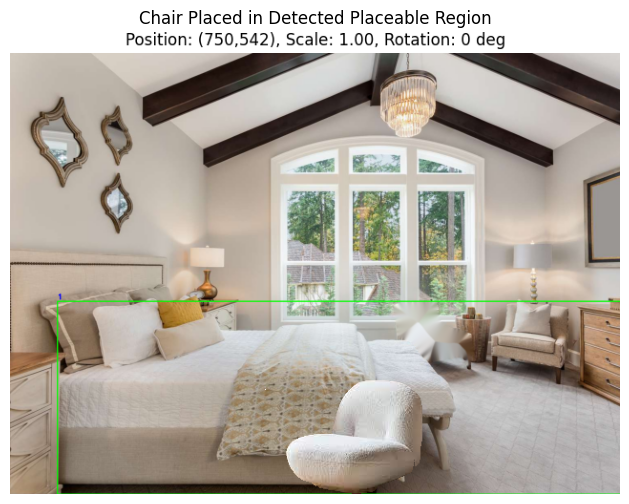

In [13]:
# === Resize and Rotate Chair ===
scaled_obj = cv2.resize(cropped_obj, (0, 0), fx=initial_scale, fy=initial_scale, interpolation=cv2.INTER_AREA)
scaled_mask = cv2.resize(cropped_mask, (0, 0), fx=initial_scale, fy=initial_scale, interpolation=cv2.INTER_NEAREST)

# Rotate to match floor alignment
rotated_obj, rotated_mask = rotate_image_and_mask(scaled_obj, scaled_mask, angle)

# Prepare binary mask for blending
object_mask_binary = rotated_mask > 0
oh, ow = rotated_obj.shape[:2]

# === Select Best Placeable Region (Largest) ===
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(placeable_mask, connectivity=8)
largest_region_idx = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
cx, cy = centroids[largest_region_idx].astype(int)

# === Compute Placement Coordinates (Center Object) ===
top_left_x = max(0, min(cx - ow // 2, img_np.shape[1] - ow))
top_left_y = max(0, min(cy - oh // 2, img_np.shape[0] - oh))

# === Place Object onto Background ===
placed_image = img_np.copy()
roi = placed_image[top_left_y:top_left_y+oh, top_left_x:top_left_x+ow]

# Mask-based blending
np.copyto(roi, rotated_obj, where=object_mask_binary[..., None])

# === Show Final Image ===
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(placed_image, cv2.COLOR_BGR2RGB))
plt.title("Chair Placed in Detected Placeable Region")
plt.axis("off")
plt.show()


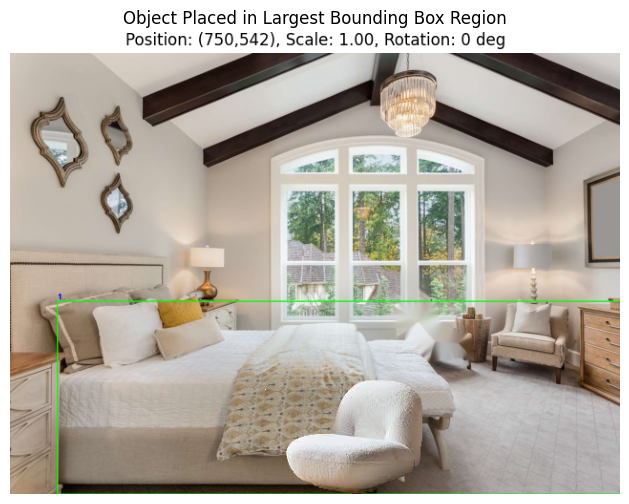

In [14]:
# === Select Target Region for Placement ===
# Use the same placeable_mask and inpainted background image as before


num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(placeable_mask, connectivity=8)

# Choose the largest placeable region (excluding label 0 which is background)
largest_region_idx = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
x_box, y_box, w_box, h_box, _ = stats[largest_region_idx]
cx, cy = centroids[largest_region_idx].astype(int)

# Resize and rotate the cropped object
scaled_obj = cv2.resize(cropped_obj, (0, 0), fx=initial_scale, fy=initial_scale, interpolation=cv2.INTER_AREA)
scaled_mask = cv2.resize(cropped_mask, (0, 0), fx=initial_scale, fy=initial_scale, interpolation=cv2.INTER_NEAREST)

# Optionally rotate object to align with floor
rotated_obj, rotated_mask = rotate_image_and_mask(scaled_obj, scaled_mask, angle)

# Compute position to center object inside the bounding box
oh, ow = rotated_obj.shape[:2]
top_left_x = cx - ow // 2
top_left_y = cy - oh // 2

# Ensure bounds are within image
top_left_x = max(0, min(top_left_x, img_np.shape[1] - ow))
top_left_y = max(0, min(top_left_y, img_np.shape[0] - oh))

# Place object into a copy of the background
placed_image = img_np.copy()
roi = placed_image[top_left_y:top_left_y+oh, top_left_x:top_left_x+ow]

# Create mask for blending
object_mask_3ch = cv2.merge([rotated_mask] * 3)
object_mask_binary = rotated_mask > 0

# Blend object using the mask
np.copyto(roi, rotated_obj, where=object_mask_binary[..., None])

# --- Show Final Output ---
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(placed_image, cv2.COLOR_BGR2RGB))
plt.title("Object Placed in Largest Bounding Box Region")
plt.axis('off')
plt.savefig("/kaggle/working/final_object_placed.png", bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
img_np = cv2.imread("/kaggle/working/phase6_input_image.png")  # Replace with actual Phase 5 output path


In [15]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import ipywidgets as widgets
from IPython.display import display
import gc

# --- Load SAM Model ---
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=16, pred_iou_thresh=0.8)

# --- Load Phase 6 Output Image ---
img_np = cv2.imread("/kaggle/working/phase6_input_image.png")
if img_np is None:
    raise FileNotFoundError("Could not load Phase 6 output image at /kaggle/working/phase6_input_image.png.")
# Downscale if necessary
max_dim = 500
h, w = img_np.shape[:2]
scale = min(max_dim / h, max_dim / w)
if scale < 1:
    img_np = cv2.resize(img_np, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
img_display = img_np[:, :, ::-1]

# --- Load and Preprocess Object Image ---
object_img = cv2.imread("/kaggle/input/image1/chair.jpeg")
if object_img is None:
    raise FileNotFoundError("Could not load /kaggle/input/image1/chair.jpeg.")
h_obj, w_obj = object_img.shape[:2]
scale_obj = min(max_dim / h_obj, max_dim / w_obj)
if scale_obj < 1:
    object_img = cv2.resize(object_img, None, fx=scale_obj, fy=scale_obj, interpolation=cv2.INTER_AREA)
object_rgb = cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB)

# --- Generate Object Mask ---
masks = mask_generator.generate(object_rgb)
if not masks:
    raise RuntimeError("No objects found with SAM.")
largest = max(masks, key=lambda m: m["area"])
mask = largest["segmentation"].astype(np.uint8)
x, y, w, h = cv2.boundingRect(mask)
cropped_obj = object_img[y:y+h, x:x+w]
cropped_mask = (mask[y:y+h, x:x+w] * 255).astype(np.uint8)
del masks, object_img, object_rgb
gc.collect()

# --- Load Previous Outputs from Phase 6 ---
assert "placeable_mask" in globals() and "depth_map" in globals() and "target_bbox" in globals()
if 'replacement_mask' not in globals():
    replacement_mask = None
if 'new_point' not in globals() or new_point is None:
    new_point = (img_np.shape[1] // 2, img_np.shape[0] // 2)

# Resize depth_map and placeable_mask to match img_np
if depth_map.shape != img_np.shape[:2]:
    depth_map = cv2.resize(depth_map, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)
if placeable_mask.shape != img_np.shape[:2]:
    placeable_mask = placeable_mask.astype(np.uint8)
    placeable_mask = cv2.resize(placeable_mask, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

# --- Helper Functions ---
def rotate_image_and_mask(img, mask, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h)), cv2.warpAffine(mask, M, (w, h))

def perspective_warp(img, mask, depth_scale):
    h, w = img.shape[:2]
    pts1 = np.float32([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])
    pts2 = pts1.copy()
    pts2[2:] += np.array([0, depth_scale * 5])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(img, matrix, (w, h)), cv2.warpPerspective(mask, matrix, (w, h))

def add_shadow(img, mask, position, scale):
    h, w = img.shape[:2]
    shadow_mask = np.zeros((h, w), dtype=np.uint8)
    center_x, center_y = position
    shadow_w = int(w * scale * 0.6)
    shadow_h = int(h * scale * 0.15)
    cv2.ellipse(shadow_mask, (center_x, center_y + int(h * 0.1)), (shadow_w//2, shadow_h//2), 0, 0, 360, 128, -1)
    shadow_mask = cv2.GaussianBlur(shadow_mask, (9, 9), 3)
    shadow = cv2.cvtColor(shadow_mask, cv2.COLOR_GRAY2BGR)
    return cv2.addWeighted(img, 1.0, shadow, 0.3, 0.0)

# --- Object Composition and Inpainting ---
def compose_and_inpaint():
    global px, py, target_bbox, x_offset, y_offset
    bx, by, bw, bh = target_bbox
    if 'new_point' in globals() and new_point is not None:
        px, py = new_point
    else:
        px, py = bx + bw // 2, by + bh // 2

    # Validate and clamp coordinates
    px = max(0, min(px, img_np.shape[1] - 1))
    py = max(0, min(py, img_np.shape[0] - 1))

    # Depth-aware scaling with fallback for empty mask
    depth_at = depth_map[py, px]
    masked_depth = depth_map[placeable_mask > 0]
    if masked_depth.size == 0:
        depth_near = 0.0  # Default near depth
        depth_far = 1.0   # Default far depth
    else:
        depth_near = np.percentile(masked_depth, 5)
        depth_far = np.percentile(masked_depth, 95)
    norm_depth = np.clip((depth_at - depth_near) / (depth_far - depth_near + 1e-6), 0.0, 1.0)
    scale_factor = 1.0 - norm_depth ** 2 * 0.6
    scale_factor = np.clip(scale_factor, 0.3, 1.0)

    # Resize object and mask, constrained by bbox
    obj_h, obj_w = cropped_obj.shape[:2]
    max_scale = min(bw / obj_w, bh / obj_h)
    new_scale = min(scale_factor, max_scale)
    new_w = int(obj_w * new_scale)
    new_h = int(obj_h * new_scale)
    obj_resized = cv2.resize(cropped_obj, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    mask_resized = cv2.resize(cropped_mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # Perspective warp
    obj_resized, mask_resized = perspective_warp(obj_resized, mask_resized, norm_depth)

    # Resize to match bbox dimensions with padding
    mask_padded = np.zeros((bh, bw), dtype=np.uint8)
    obj_padded = np.zeros((bh, bw, 3), dtype=np.uint8)
    h_offset = (bh - mask_resized.shape[0]) // 2
    w_offset = (bw - mask_resized.shape[1]) // 2
    h_start = max(0, h_offset)
    w_start = max(0, w_offset)
    h_end = min(bh, h_start + mask_resized.shape[0])
    w_end = min(bw, w_start + mask_resized.shape[1])
    mask_padded[h_start:h_end, w_start:w_end] = mask_resized[:h_end-h_start, :w_end-w_start]
    obj_padded[h_start:h_end, w_start:w_end] = obj_resized[:h_end-h_start, :w_end-w_start]

    # Extract object using padded mask (remove background)
    obj_extracted = np.zeros_like(obj_padded)
    obj_extracted[mask_padded > 0] = obj_padded[mask_padded > 0]

    # Align within bbox (start at top-left of bbox)
    x_offset = bx
    y_offset = by

    # Initial composite with inpainting if replacement_mask exists
    initial_inpaint = cv2.inpaint(img_np, (replacement_mask * 255).astype(np.uint8) if replacement_mask is not None else np.zeros_like(img_np, dtype=np.uint8), 3, cv2.INPAINT_NS) if replacement_mask is not None else img_np.copy()

    # Place object using seamless cloning
    blended = cv2.seamlessClone(obj_extracted, initial_inpaint, mask_padded, (bx + bw//2, by + bh//2), cv2.NORMAL_CLONE)

    # Composite mask for final inpainting
    composite_mask = np.zeros_like(placeable_mask, dtype=np.uint8)
    composite_mask[by:by+bh, bx:bx+bw] = mask_padded
    if replacement_mask is not None:
        composite_mask = np.logical_or(composite_mask, replacement_mask).astype(np.uint8) * 255

    # Final inpainting to smooth edges
    inpainted_img = cv2.inpaint(blended, composite_mask, 3, cv2.INPAINT_NS)

    # Add shadow
    final_img = add_shadow(inpainted_img, composite_mask, (bx + bw//2, by + bh//2), new_scale)

    # --- Interactive Preview ---
    def update_preview(x_offset=bx, y_offset=by, scale_slider=1.0, angle_slider=0):
        new_scale = min(scale_factor * scale_slider, max_scale)
        new_w_scaled = int(obj_w * new_scale)
        new_h_scaled = int(obj_h * new_scale)
        obj_scaled = cv2.resize(cropped_obj, (new_w_scaled, new_h_scaled), interpolation=cv2.INTER_CUBIC)
        mask_scaled = cv2.resize(cropped_mask, (new_w_scaled, new_h_scaled), interpolation=cv2.INTER_NEAREST)

        if angle_slider != 0:
            obj_scaled, mask_scaled = rotate_image_and_mask(obj_scaled, mask_scaled, angle_slider)

        # Resize to match bbox dimensions with padding
        mask_padded_adj = np.zeros((bh, bw), dtype=np.uint8)
        obj_padded_adj = np.zeros((bh, bw, 3), dtype=np.uint8)
        h_offset = (bh - mask_scaled.shape[0]) // 2
        w_offset = (bw - mask_scaled.shape[1]) // 2
        h_start = max(0, h_offset)
        w_start = max(0, w_offset)
        h_end = min(bh, h_start + mask_scaled.shape[0])
        w_end = min(bw, w_start + mask_scaled.shape[1])
        mask_padded_adj[h_start:h_end, w_start:w_end] = mask_scaled[:h_end-h_start, :w_end-w_start]
        obj_padded_adj[h_start:h_end, w_start:w_end] = obj_scaled[:h_end-h_start, :w_end-w_start]

        # Extract object using padded mask
        obj_extracted_scaled = np.zeros_like(obj_padded_adj)
        obj_extracted_scaled[mask_padded_adj > 0] = obj_padded_adj[mask_padded_adj > 0]

        x_off = bx
        y_off = by

        initial_inpaint_adj = cv2.inpaint(img_np, (replacement_mask * 255).astype(np.uint8) if replacement_mask is not None else np.zeros_like(img_np, dtype=np.uint8), 3, cv2.INPAINT_NS) if replacement_mask is not None else img_np.copy()
        blended_adj = cv2.seamlessClone(obj_extracted_scaled, initial_inpaint_adj, mask_padded_adj, (bx + bw//2, by + bh//2), cv2.NORMAL_CLONE)
        composite_mask_adj = np.zeros_like(placeable_mask, dtype=np.uint8)
        composite_mask_adj[by:by+bh, bx:bx+bw] = mask_padded_adj
        if replacement_mask is not None:
            composite_mask_adj = np.logical_or(composite_mask_adj, replacement_mask).astype(np.uint8) * 255
        inpainted_adj = cv2.inpaint(blended_adj, composite_mask_adj, 3, cv2.INPAINT_NS)
        final_img_adj = add_shadow(inpainted_adj, composite_mask_adj, (bx + bw//2, by + bh//2), new_scale)

        plt.figure(figsize=(8, 5))
        plt.imshow(final_img_adj)
        plt.gca().add_patch(plt.Rectangle((bx, by), bw, bh, linewidth=2, edgecolor='green', facecolor='none'))
        plt.title(f"Scale: {scale_slider:.2f}, Rotation: {angle_slider} deg, Pos: ({bx},{by})")
        plt.axis("off")
        plt.show()
        del final_img_adj, inpainted_adj, composite_mask_adj, blended_adj, initial_inpaint_adj
        gc.collect()
        print(f"Displayed preview at position ({bx}, {by}) with scale {scale_slider} and rotation {angle_slider}.")

    interact_widget = widgets.interact(update_preview,
                                      x_offset=widgets.IntSlider(value=bx, min=0, max=img_np.shape[1]-bw, description="X Offset"),
                                      y_offset=widgets.IntSlider(value=by, min=0, max=img_np.shape[0]-bh, description="Y Offset"),
                                      scale_slider=widgets.FloatSlider(value=1.0, min=0.3, max=1.5, step=0.05, description="Scale"),
                                      angle_slider=widgets.IntSlider(value=0, min=-45, max=45, step=5, description="Rotation"))
    display(interact_widget)

    print(f"📍 Final insertion point: ({px}, {py})")
    print(f"📏 Final target bounding box: {target_bbox}")
    return final_img, px, py, target_bbox, x_offset, y_offset

if __name__ == "__main__":
    final_image, final_x, final_y, final_bbox, x_offset, y_offset = compose_and_inpaint()


AssertionError: 

In [17]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from skimage.metrics import structural_similarity as ssim

# --- Load Previous Outputs ---
assert "final_image" in globals() and "img_np" in globals()

# --- Color Harmonization ---
def harmonize_colors(base_img, object_img, mask):
    # Convert to LAB color space for better color matching
    base_lab = cv2.cvtColor(base_img, cv2.COLOR_BGR2LAB)
    object_lab = cv2.cvtColor(object_img, cv2.COLOR_BGR2LAB)

    # Match color statistics (mean and std) of object to base image
    h, w = mask.shape[:2]
    for c in range(1, 3):  # L channel (0) is preserved, adjust A and B
        base_mean, base_std = cv2.meanStdDev(base_lab[:, :, c])[0][0], cv2.meanStdDev(base_lab[:, :, c])[1][0]
        object_mean, object_std = cv2.meanStdDev(object_lab[y_offset:y_offset+h, x_offset:x_offset+w, c])[0][0], cv2.meanStdDev(object_lab[y_offset:y_offset+h, x_offset:x_offset+w, c])[1][0]
        object_lab[y_offset:y_offset+h, x_offset:x_offset+w, c] = np.clip((object_lab[y_offset:y_offset+h, x_offset:x_offset+w, c] - object_mean) * (base_std / (object_std + 1e-6)) + base_mean, 0, 255).astype(np.uint8)

    harmonized = cv2.cvtColor(object_lab, cv2.COLOR_LAB2BGR)
    final_img_harmonized = base_img.copy()
    final_img_harmonized[y_offset:y_offset+h, x_offset:x_offset+w] = harmonized[y_offset:y_offset+h, x_offset:x_offset+w]
    return final_img_harmonized

# --- Quality Check ---
def evaluate_quality(original, enhanced):
    # Convert to grayscale for SSIM
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(original_gray, enhanced_gray, full=True)
    print(f"📊 SSIM Quality Score: {score:.4f}")
    return score > 0.9  # Threshold for acceptable quality

# --- Refinement and Output ---
def refine_and_output(final_img, x_offset, y_offset):
    global img_np
    # Harmonize colors
    h, w = cropped_obj.shape[:2]
    harmonized_img = harmonize_colors(img_np, final_img, np.zeros_like(placeable_mask))

    # Basic enhancement (optional brightness/contrast adjustment)
    alpha = 1.2  # Contrast
    beta = 10    # Brightness
    enhanced_img = cv2.convertScaleAbs(harmonized_img, alpha=alpha, beta=beta)
    enhanced_img = np.clip(enhanced_img, 0, 255).astype(np.uint8)

    # Quality evaluation
    is_quality_acceptable = evaluate_quality(img_np, enhanced_img)

    if is_quality_acceptable:
        print("✅ Image quality is acceptable. Ready for presentation.")
    else:
        print("⚠️ Image quality below threshold. Consider further refinement.")

    # Save and display
    cv2.imwrite("final_output.jpg", enhanced_img)
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
    plt.title("Final Photorealistic Output")
    plt.axis("off")
    plt.show()
    return enhanced_img

# --- Execute Refinement ---
if __name__ == "__main__":
    refined_image = refine_and_output(final_image, x_offset, y_offset)


AssertionError: 